In [1]:
import os

import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors


In [2]:
# check whether we are in the right directory
os.getcwd() + "/database/" + os.listdir("database")[0]


'/scratch/amw9425/robot-hw/HW2/database/image27487.png'

In [3]:
"""
Extract featues using SIFT, and store them in a list.
"""


def extract_features(image, extractor):

    # compute descriptors
    keypoints, descriptors = extractor.detectAndCompute(image, None)

    return keypoints, descriptors


In [4]:
# define helper variables
keypoint_list, descriptor_list = [], []
extractor = cv2.SIFT_create()
data_path = "database"
query_path = "queries"


In [5]:
# compute descriptor for all images in the database
for img_path in tqdm(os.listdir(data_path), desc="Feature extraction: "):

    # access curent image and convert it to grayscale
    curr_img_path = os.getcwd() + "/" + data_path + "/" + img_path
    curr_img = cv2.imread(curr_img_path, cv2.IMREAD_GRAYSCALE)

    # compute descriptors
    keypoints, descriptors = extract_features(curr_img, extractor)

    # store keypoints and descriptors
    keypoint_list.append(keypoints)
    descriptor_list.append(descriptors)


Feature extraction: 100%|██████████| 28600/28600 [09:11<00:00, 51.82it/s]


In [6]:
# vertically stack sift features to be fed into K means clustering
descriptor_list = np.vstack(tuple(descriptor_list))


In [7]:
descriptor_list.shape


(6170917, 128)

In [8]:
"""
Compute 300 clusters of descriptors. Using minibatch k means because 
it converges faster( according to scipy documentation)
"""

# define the k means model minibatch, default batch size - 1024
model = MiniBatchKMeans(n_clusters=300)

# compute clusters
model.fit(descriptor_list)


MiniBatchKMeans(n_clusters=300)

In [9]:
# check whether we got 300 clusters
model.cluster_centers_.shape


(300, 128)

In [10]:
# function to generate histograms using the extracted features and k means clusters
def build_histogram(descriptor_list, model):
    histogram = np.zeros(len(model.cluster_centers_))
    cluster_result = model.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram


In [11]:
# create numpy arrays to store the histograms of 300 visual words
histogram_data = np.zeros((len(os.listdir(data_path)), 300))
histogram_query = np.zeros((len(os.listdir(query_path)), 300))


In [12]:
# compute histogram for all images in the database
for idx, img_path in enumerate(
    tqdm(os.listdir(data_path), desc="Feature extraction: ")
):

    # access curent image and convert it to grayscale
    curr_img_path = os.getcwd() + "/" + data_path + "/" + img_path
    curr_img = cv2.imread(curr_img_path, cv2.IMREAD_GRAYSCALE)

    # compute features
    keypoints, descriptors = extract_features(curr_img, extractor)

    # compute histogram
    histogram = build_histogram(descriptors, model)

    # store histogram
    histogram_data[idx] = histogram


Feature extraction: 100%|██████████| 28600/28600 [02:05<00:00, 227.17it/s]


In [13]:
# compute histogram for all images in the queries
for idx, img_path in enumerate(
    tqdm(os.listdir(query_path), desc="Feature extraction: ")
):

    # access curent image and convert it to grayscale
    curr_img_path = os.getcwd() + "/" + query_path + "/" + img_path
    curr_img = cv2.imread(curr_img_path, cv2.IMREAD_GRAYSCALE)

    # compute features
    keypoints, descriptors = extract_features(curr_img, extractor)

    # compute histogram
    histogram = build_histogram(descriptors, model)

    # store histogram
    histogram_query[idx] = histogram


Feature extraction: 100%|██████████| 5/5 [00:00<00:00, 113.61it/s]


In [14]:
# compute a single histogram to find out the frequency of visual words to use with if-idf step
histogram_data_combined = build_histogram(descriptor_list, model)


In [25]:
knn = NearestNeighbors(n_neighbors=16)
knn.fit(histogram_data)

distance, nearest_index = knn.kneighbors(histogram_query)


In [26]:
nearest_index


array([[25081, 23980, 28536, 20180,  7137,  7667, 27163, 27657,  4270,
         6484,  1106, 22300, 24824,   608,  8915,   756],
       [25433, 18650, 26470, 11215,  1111, 17501,  5119,  6366, 24917,
        20075, 11837,  8656,  8559, 11911,  3966,  9266],
       [20675,  9699,  8549,  1290,   982, 25458, 27919, 24397, 15477,
        25905, 16045, 19059,  4926, 18603,  5194, 21276],
       [  206, 13757, 19679,  7128, 10698, 14712, 15042, 11212, 13574,
         8162,  3951,  4301, 16852, 11072, 17244, 24303],
       [20873,  3638, 15921,  9618, 24849,  5824, 28200, 23443, 14171,
        21600, 14080,  6232, 22767, 13733, 20911, 11300]])

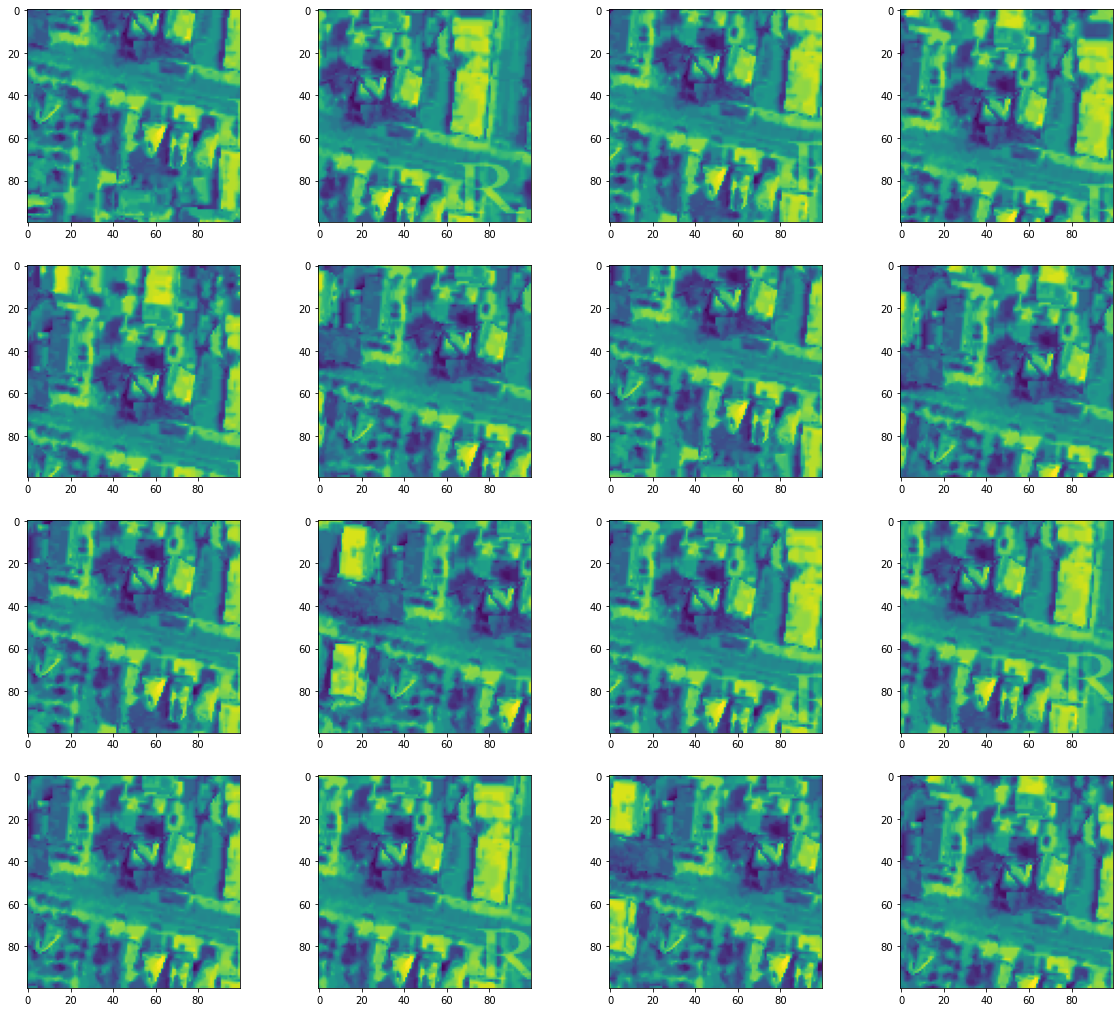

In [32]:
fig = plt.figure(figsize=(20, 18))
n = 1

# show all images corresponding to each query
for idx, img_path in enumerate(os.listdir(data_path)):
    if idx in nearest_index[0]:
        fig.add_subplot(4, 4, n)
        n += 1
        # read curent image
        curr_img_path = os.getcwd() + "/" + data_path + "/" + img_path
        curr_img = cv2.imread(curr_img_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(curr_img)


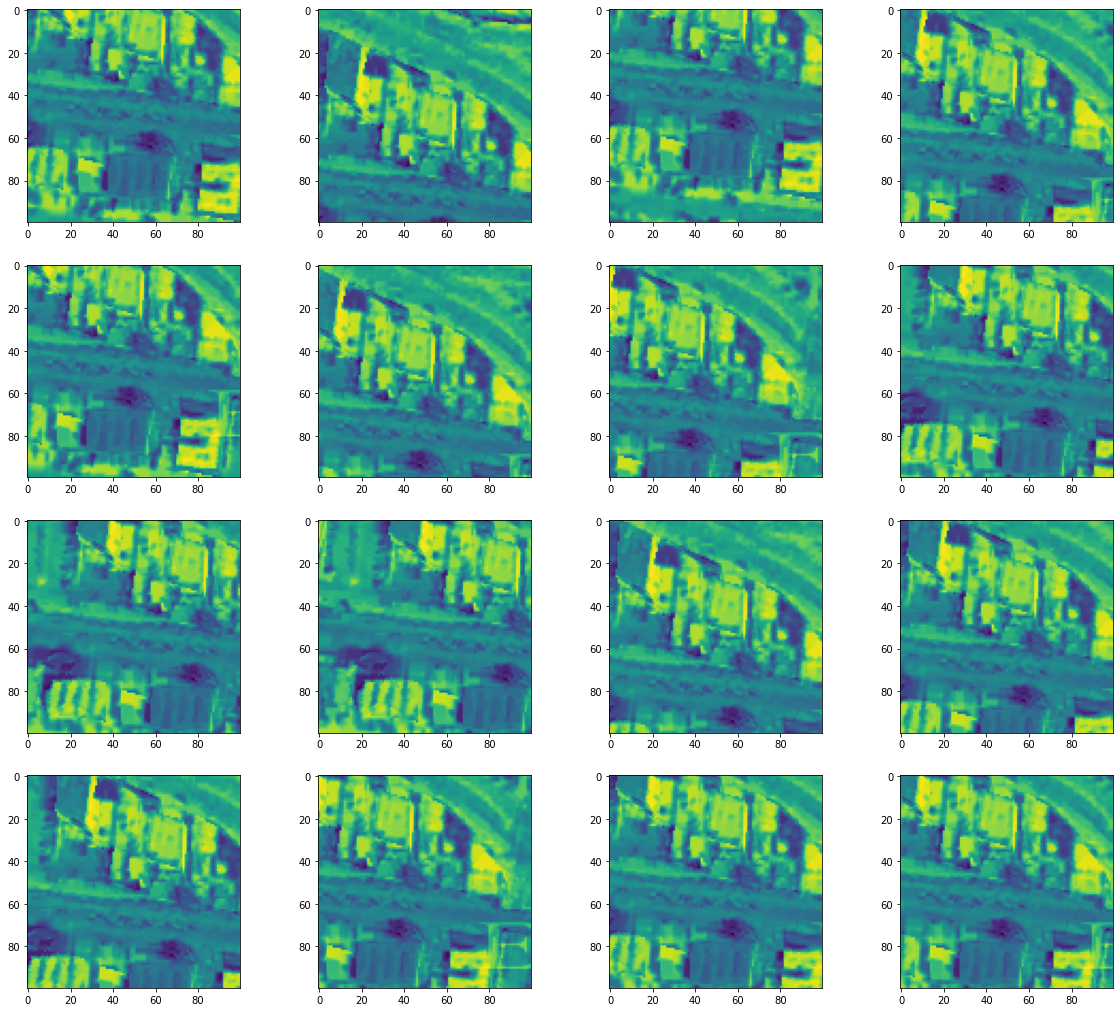

In [33]:
fig = plt.figure(figsize=(20, 18))
n = 1

# show all images corresponding to each query
for idx, img_path in enumerate(os.listdir(data_path)):
    if idx in nearest_index[1]:
        fig.add_subplot(4, 4, n)
        n += 1
        # read curent image
        curr_img_path = os.getcwd() + "/" + data_path + "/" + img_path
        curr_img = cv2.imread(curr_img_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(curr_img)


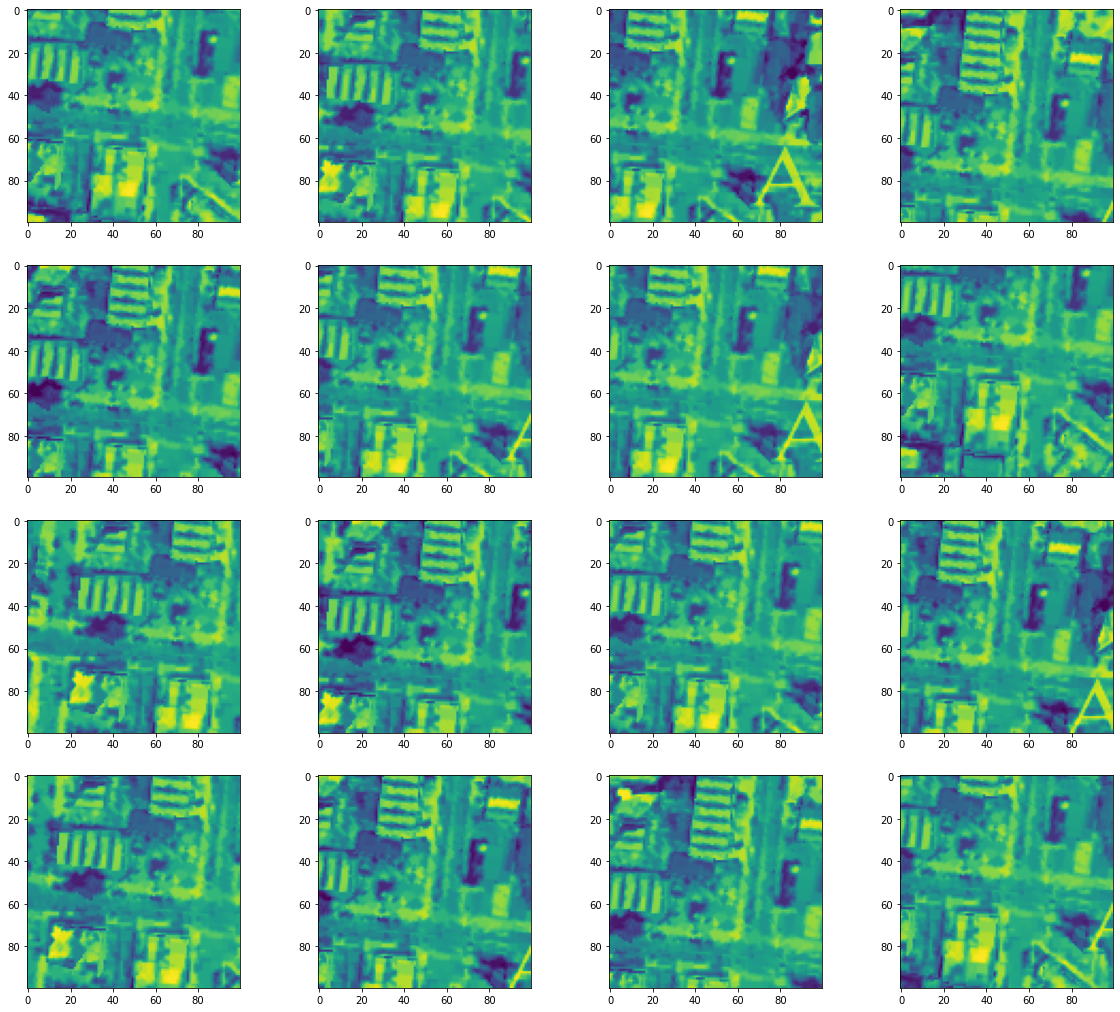

In [34]:
fig = plt.figure(figsize=(20, 18))
n = 1

# show all images corresponding to each query
for idx, img_path in enumerate(os.listdir(data_path)):
    if idx in nearest_index[2]:
        fig.add_subplot(4, 4, n)
        n += 1
        # read curent image
        curr_img_path = os.getcwd() + "/" + data_path + "/" + img_path
        curr_img = cv2.imread(curr_img_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(curr_img)


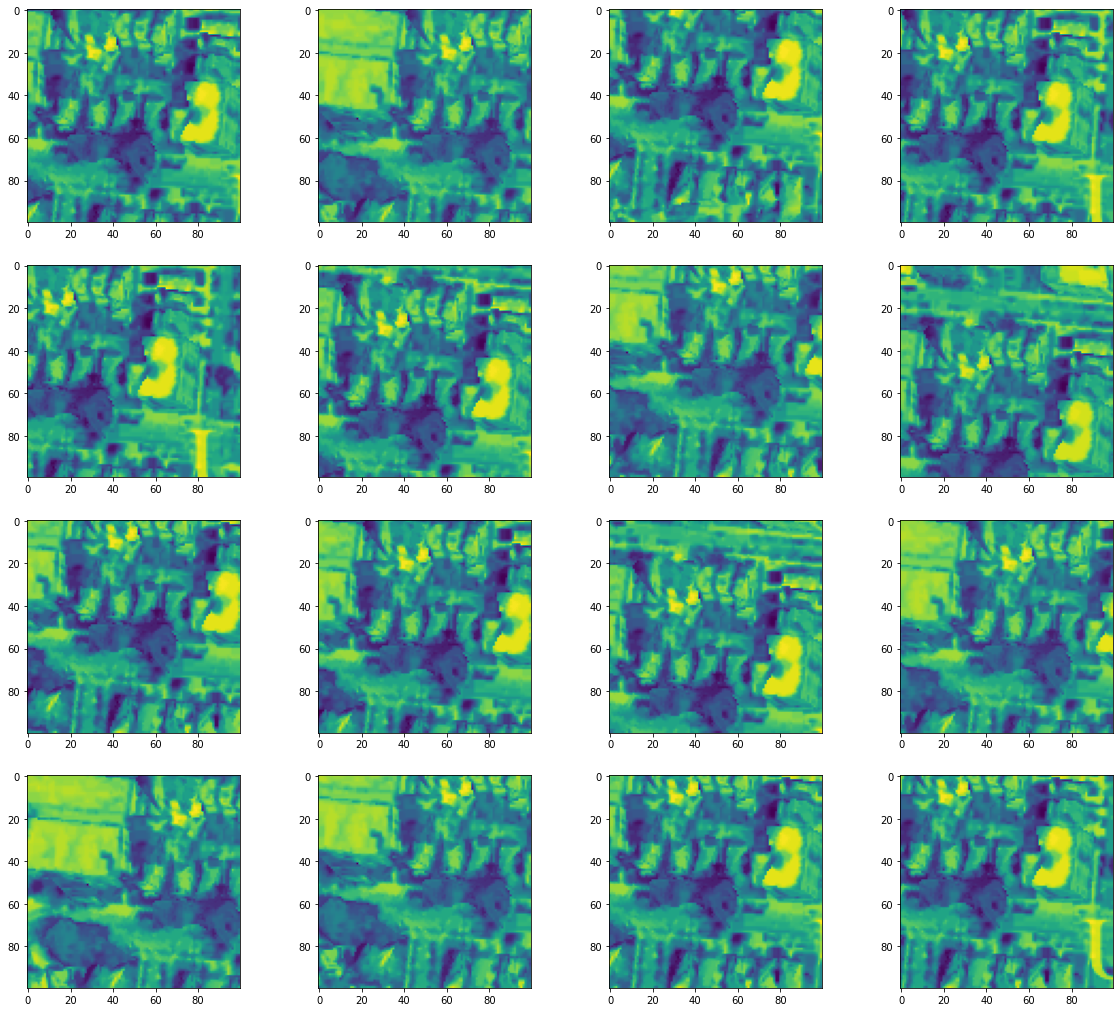

In [35]:
fig = plt.figure(figsize=(20, 18))
n = 1

# show all images corresponding to each query
for idx, img_path in enumerate(os.listdir(data_path)):
    if idx in nearest_index[3]:
        fig.add_subplot(4, 4, n)
        n += 1
        # read curent image
        curr_img_path = os.getcwd() + "/" + data_path + "/" + img_path
        curr_img = cv2.imread(curr_img_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(curr_img)


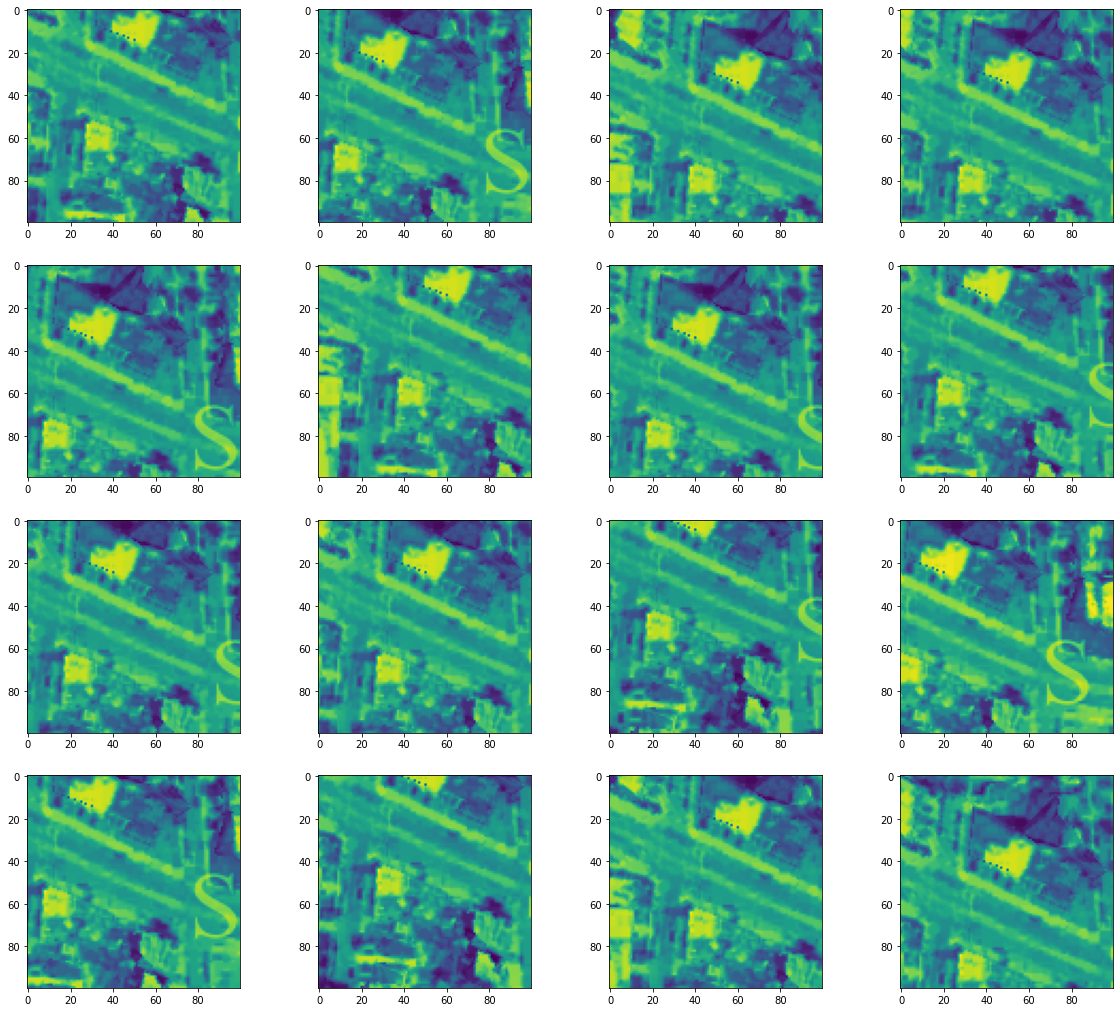

In [36]:
fig = plt.figure(figsize=(20, 18))
n = 1

# show all images corresponding to each query
for idx, img_path in enumerate(os.listdir(data_path)):
    if idx in nearest_index[4]:
        fig.add_subplot(4, 4, n)
        n += 1
        # read curent image
        curr_img_path = os.getcwd() + "/" + data_path + "/" + img_path
        curr_img = cv2.imread(curr_img_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(curr_img)


# CODE - REAUS